# Data Scientist Professional Practical Exam Submission
## Necessary Imports and Data Overview

In [1]:
# !pip install phik

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, precision_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split

In [122]:
df = pd.read_csv('recipe_site_traffic_2212.csv')
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [123]:
# Data overview
print('Data info:')
print(df.info())
print('\nSummary statistics for numeric features:')
display(df.describe())
print('\nSummary statistics for categorical features:')
display(df.describe(include='O'))
print(f"\nUnique values for 'Category': {df['category'].unique()}")
print(f"Unique values for 'Servings': {df['servings'].unique()}")
print(f"Unique values for 'High traffic': {df['high_traffic'].unique()}")

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB
None

Summary statistics for numeric features:


,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000



Summary statistics for categorical features:


,category,servings,high_traffic
count,947,947,574
unique,11,6,1
top,Breakfast,4,High
freq,106,389,574



Unique values for 'Category': ['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']
Unique values for 'Servings': ['6' '4' '1' '2' '4 as a snack' '6 as a snack']
Unique values for 'High traffic': ['High' nan]


## Part I. Data Validation

The dataset contains eight columns and 947 rows. The only column that does not need to be cleaned is **'recipe'** (numeric variable without missing values). Though, the only purpose of this column is to keep track of the observations, so I've used it as an index. With regard to the cleaning part:

1. I've decided to begin the cleaning process with the **'category'** column _(character variable, indicating the type of a recipe)_. The description claims that there are only 10 possible unique values for this column; however, in reality, there is one more value (not listed in the description) — 'Chicken Breast'. Given that other types of dishes made of animals (i.e., 'Meat', 'Pork') are not split into further categories (e.g., 'Steak' or 'Loin'), it is, in my opinion, reasonable to make all 'Chicken Breast' values to be simply 'Chicken'.
2. After doing so, I've decided to deal with the missing values in four numeric columns: **'calories', 'carbohydrate', 'sugar', 'protein'** _(same as the description)_. Instead of simply dropping them, I've imputed the missing values for each of the four mentioned columns with the means of the category they belong to.
3. Then I've decided to apply the One-Hot Encoding method on the updated **'category'** column to create 10 new columns corresponding to 10 unique values of the 'category' column.
4. The **'servings'** column _(number of servings for the recipe)_ has mostly numeric observations (944); however, there are three non-numeric ones (corresponding to the values '4 as a snack' and '6 as a snack'). In order not to make the data for our model too noisy, I've just dropped these three strange observations. 
5. Finally, considering the values of our target variable **('high_traffic')**: 'High' and None, I've converted this column to binary form, where 1 indicates high traffic and 0 means no high traffic. 

You can see the code for this part below:

In [124]:
# Step 0: use recipe as an index
df.set_index('recipe', inplace=True)
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,NaN,NaN,NaN,NaN,Pork,6,High
2,35.48,38.56,0.66,0.92,Potato,4,High
3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
4,97.03,30.56,38.63,0.02,Beverages,4,High
5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [125]:
# Step 1: convert Chicken Breast to Chicken
for i, val in enumerate(df['category'].values):
    if val == 'Chicken Breast':
        df['category'].values[i] = 'Chicken'

In [126]:
# Step 2: deal with missing values in 'calories', 'carbohydrate', 'sugar' and 'protein'
df['calories'] = df.groupby('category')['calories'].transform(
    lambda x: x.fillna(round(x.mean(), 2)) if x.isnull().any() else x)

df['carbohydrate'] = df.groupby('category')['carbohydrate'].transform(
    lambda x: x.fillna(round(x.mean(), 2)) if x.isnull().any() else x)

df['sugar'] = df.groupby('category')['sugar'].transform(
    lambda x: x.fillna(round(x.mean(), 2)) if x.isnull().any() else x)

df['protein'] = df.groupby('category')['protein'].transform(
    lambda x: x.fillna(round(x.mean(), 2)) if x.isnull().any() else x)

In [127]:
# Step 3: dummies for category
dummies = pd.get_dummies(df['category'])
dummy_df = pd.concat([df.drop('category', axis=1), dummies], axis=1)
dummy_df.head()

,calories,carbohydrate,sugar,protein,servings,high_traffic,Beverages,Breakfast,Chicken,Dessert,Lunch/Snacks,Meat,One Dish Meal,Pork,Potato,Vegetable
recipe,,,,,,,,,,,,,,,,
1,629.71,28.08,8.04,43.80,6,High,0,0,0,0,0,0,0,1,0,0
2,35.48,38.56,0.66,0.92,4,High,0,0,0,0,0,0,0,0,1,0
3,914.28,42.68,3.09,2.88,1,NaN,0,1,0,0,0,0,0,0,0,0
4,97.03,30.56,38.63,0.02,4,High,1,0,0,0,0,0,0,0,0,0
5,27.05,1.85,0.80,0.53,4,NaN,1,0,0,0,0,0,0,0,0,0


In [128]:
# Step 4: remove '4 as a snack' and '6 as a snack' from 'servings'
print(dummy_df['servings'].value_counts())
dummy_df = dummy_df[(dummy_df['servings'] != '4 as a snack') & (dummy_df['servings'] != '6 as a snack')]

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64


In [129]:
print(dummy_df['servings'].value_counts())
dummy_df['servings'] = dummy_df['servings'].astype(int)

4    389
6    197
2    183
1    175
Name: servings, dtype: int64


In [130]:
# Step 5: target variable to binary form
dummy_df['high_traffic'] = dummy_df['high_traffic'].apply(lambda x: 1 if x == 'High' else 0)
dummy_df.head()

,calories,carbohydrate,sugar,protein,servings,high_traffic,Beverages,Breakfast,Chicken,Dessert,Lunch/Snacks,Meat,One Dish Meal,Pork,Potato,Vegetable
recipe,,,,,,,,,,,,,,,,
1,629.71,28.08,8.04,43.80,6,1,0,0,0,0,0,0,0,1,0,0
2,35.48,38.56,0.66,0.92,4,1,0,0,0,0,0,0,0,0,1,0
3,914.28,42.68,3.09,2.88,1,0,0,1,0,0,0,0,0,0,0,0
4,97.03,30.56,38.63,0.02,4,1,1,0,0,0,0,0,0,0,0,0
5,27.05,1.85,0.80,0.53,4,0,1,0,0,0,0,0,0,0,0,0


In [131]:
# Check the data one more time
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 944 entries, 1 to 947
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   calories       944 non-null    float64
 1   carbohydrate   944 non-null    float64
 2   sugar          944 non-null    float64
 3   protein        944 non-null    float64
 4   servings       944 non-null    int64  
 5   high_traffic   944 non-null    int64  
 6   Beverages      944 non-null    uint8  
 7   Breakfast      944 non-null    uint8  
 8   Chicken        944 non-null    uint8  
 9   Dessert        944 non-null    uint8  
 10  Lunch/Snacks   944 non-null    uint8  
 11  Meat           944 non-null    uint8  
 12  One Dish Meal  944 non-null    uint8  
 13  Pork           944 non-null    uint8  
 14  Potato         944 non-null    uint8  
 15  Vegetable      944 non-null    uint8  
dtypes: float64(4), int64(2), uint8(10)
memory usage: 60.8 KB


## Part II. Exploratory Analysis
### Target (High Traffic)
I've investigated the target variable and the features of our dataset. As for the target variable, on the graph below, you can see a little class disbalance, though, it's not a big issue for us, so we won't make any changes, considering the 'high_traffic' column:

In [132]:
sns.set_palette('viridis')
sns.set_style('darkgrid')

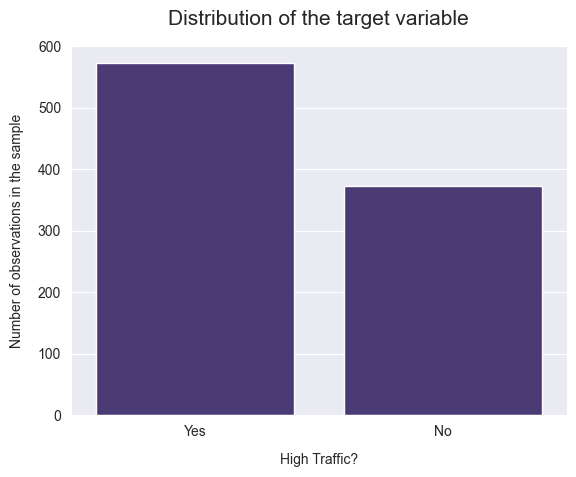

In [133]:
df_for_viz = dummy_df.copy()
df_for_viz['high_traffic'] = df_for_viz['high_traffic'].apply(lambda x: 'No' if x == 0 else 'Yes')

sns.countplot(x=df_for_viz['high_traffic']).set_title(
    'Distribution of the target variable', pad=15, fontsize=15)
plt.xlabel('High Traffic?', labelpad=10)
plt.ylabel('Number of observations in the sample', labelpad=10)
plt.show()

### Dummy Variables
The chart below illustrates the distribution of the recipe categories in our data. Generally, it looks pretty well-balanced (except for the 'Chicken' category), so no further changes are needed, in my opinion:

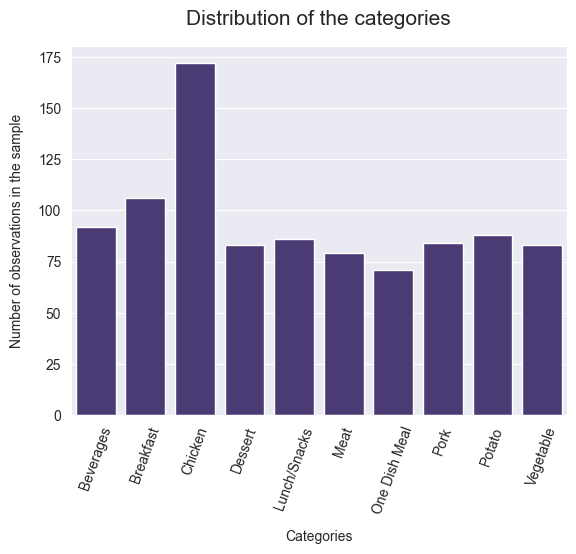

In [134]:
df_for_viz = dummy_df.drop(
    ['carbohydrate', 'sugar', 'protein', 'servings', 'high_traffic'], 
    axis=1)
df_for_viz = df_for_viz.melt('calories', var_name='Categories', value_name='vals')
df_for_viz = df_for_viz[df_for_viz.vals != 0]

sns.countplot(data=df_for_viz, x='Categories').set_title(
    'Distribution of the categories', pad=15, fontsize=15)
plt.xlabel('Categories', labelpad=10)
plt.ylabel('Number of observations in the sample', labelpad=10)
plt.xticks(rotation=70)
plt.show()

### Numeric Variables
On the four diagrams below, you can see the distributions of our original numeric features:

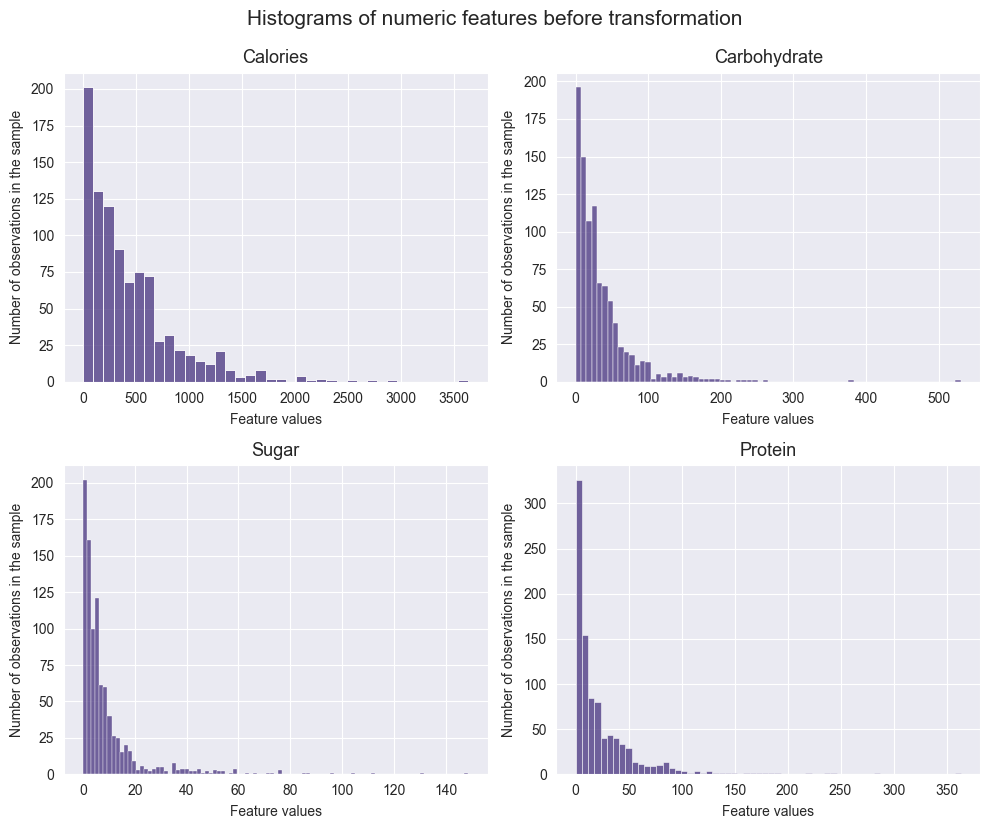

In [135]:
plt.figure(figsize=(10, 8))

for i, variable in enumerate(['calories', 'carbohydrate', 'sugar', 'protein'], 1):
    plt.subplot(2, 2, i)
    sns.histplot(dummy_df[variable])
    plt.title(variable.title(), pad=7, fontsize=13)
    plt.xlabel('Feature values', labelpad=5)
    plt.ylabel('Number of observations in the sample', labelpad=5)

plt.tight_layout()
plt.suptitle('Histograms of numeric features before transformation', y=1.03, fontsize=15)
plt.show()

Most importantly, the distributions of our numeric variables are far from normal, so I've applied the **square root transformation** to all of them to approximate the normal distribution. As it can be observed from the graphs below, the distributions of the numeric features became less right-skewed than before:

In [136]:
sqrt_df = dummy_df.drop(['calories', 'carbohydrate', 'sugar', 'protein'], axis=1).copy()

sqrt_df['sqrt_calories'] = np.sqrt(dummy_df['calories'])
sqrt_df['sqrt_carbohydrate'] = np.sqrt(dummy_df['carbohydrate'])
sqrt_df['sqrt_sugar'] = np.sqrt(dummy_df['sugar'])
sqrt_df['sqrt_protein'] = np.sqrt(dummy_df['protein'])

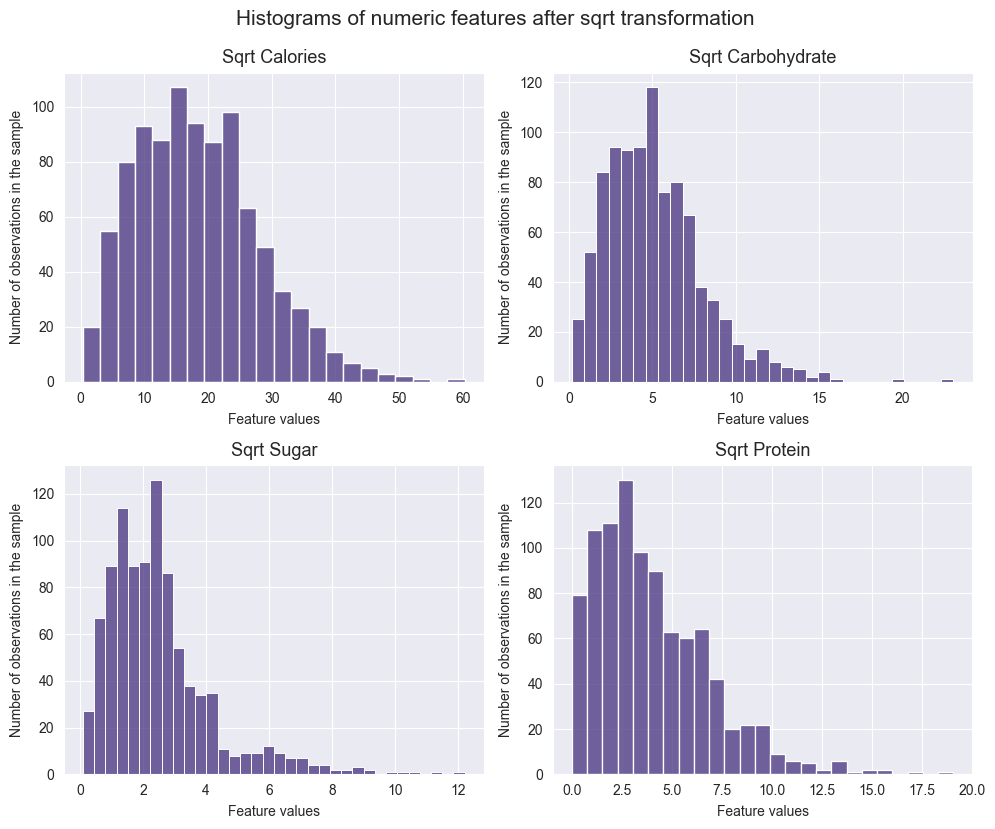

In [137]:
plt.figure(figsize=(10, 8))

for i, variable in enumerate(['sqrt_calories', 'sqrt_carbohydrate', 'sqrt_sugar', 'sqrt_protein'], 1):
    plt.subplot(2, 2, i)
    sns.histplot(sqrt_df[variable])
    plt.title(variable.title().replace('_', ' '), pad=7, fontsize=13)
    plt.xlabel('Feature values', labelpad=5)
    plt.ylabel('Number of observations in the sample', labelpad=5)

plt.tight_layout()
plt.suptitle('Histograms of numeric features after sqrt transformation', y=1.03, fontsize=15)
plt.show()

### Relationships between Features and the Target
The correlation heat map below indicates that there are no linear relationships between our numeric features and the target variable, thus, it may be a good choice to use one non-linear model for the machine learning part:

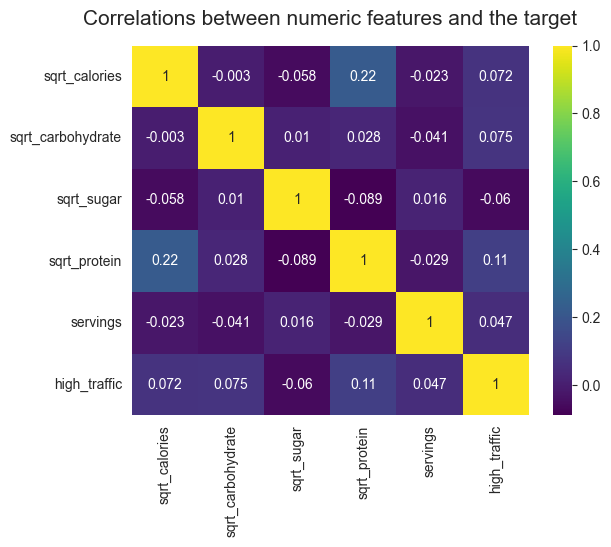

In [138]:
# We are using Spearman's rank correlation coefficient for non-normally distributed variables
sns.heatmap(data=sqrt_df[['sqrt_calories', 'sqrt_carbohydrate', \
                           'sqrt_sugar', 'sqrt_protein', 'servings', \
                          'high_traffic']].corr(method='spearman'), 
                            cmap='viridis', annot=True). \
            set_title('Correlations between numeric features and the target', pad=15, fontsize=15)

plt.show()

On the other hand, some of our dummy variables are moderately correlated with the target, so we will use a linear model as well:

interval columns not set, guessing: ['high_traffic', 'Beverages', 'Breakfast', 'Chicken', 'Dessert', 'Lunch/Snacks', 'Meat', 'One Dish Meal', 'Pork', 'Potato', 'Vegetable']


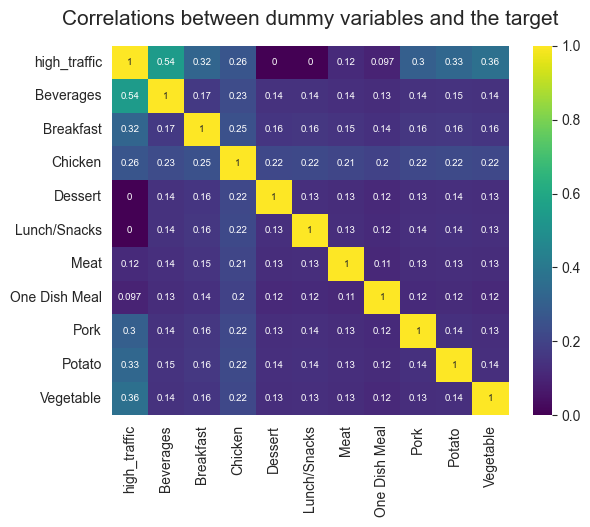

In [139]:
# We are using Phi correlation coefficient for binary variables
sns.heatmap(data=sqrt_df.drop(['sqrt_calories', 'sqrt_carbohydrate', \
                           'sqrt_sugar', 'sqrt_protein', 'servings'],
                             axis=1).phik_matrix(), 
                            cmap='viridis', annot=True, annot_kws={'size': 7}). \
            set_title('Correlations between dummy variables and the target', pad=15, fontsize=15)

plt.show()

### Further Data Investigation. Outliers
Which recipes contain the highest and the lowest amount of calories (measured by the square root of calories in a recipe)?

Pork recipes have highest median of square root of calories, while Beverages and Vegetable ones have the lowest medians. In addition, from the boxplots below we can see that the **problem of outliers (i.e., extreme values) is virtually absent in our data** due to the square root transformation applied earlier. Thus, we are fully prepared to proceed to the ML part:

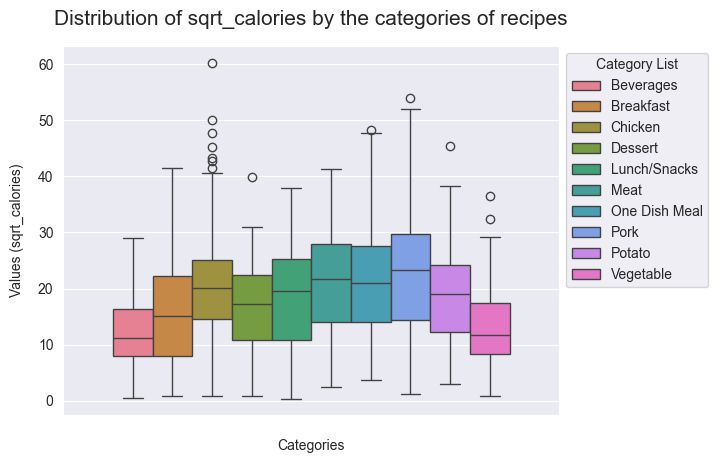

In [140]:
df_for_viz = sqrt_df.drop(
    ['sqrt_carbohydrate', 'sqrt_sugar', 'sqrt_protein', 'servings', 'high_traffic'], 
    axis=1)
df_for_viz = df_for_viz.melt('sqrt_calories', var_name='Category List', value_name='vals')
df_for_viz = df_for_viz[df_for_viz.vals != 0]

ax = sns.boxplot(data=df_for_viz, y='sqrt_calories', hue='Category List')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

plt.title('Distribution of sqrt_calories by the categories of recipes', pad=15, fontsize=15)
plt.xlabel('Categories', labelpad=10)
plt.ylabel('Values (sqrt_calories)', labelpad=10)
plt.show()

## Part III. Modelling, Fitting & Evaluating
We are dealing with the classification problem when trying to predict the values of a binary target variable. I've chosen two models, which, as far as I'm concerned, are the most suitable for the data: **Logistic Regression and Random Forest**. 

To evaluate, which model performs better on our data, I've used the **ROC AUC score** _(a metric that measures model's ability to distinguish between classes, where a higher value indicates better performance)_ because it's resistant to class imbalance, unlike a more popular metric — accuracy. 

First, I've split the data into train and test subsets, then I've fitted the models on the training data and assessed their results on the test data:

In [141]:
# Split the data into train and test (stratifying by target)
X = sqrt_df.drop(['high_traffic'], axis=1)
y = sqrt_df['high_traffic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=42)

In [142]:
# Fit both models and predict target values
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
pred_proba_logreg = logreg.predict_proba(X_test)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
pred_proba_rf = rf.predict_proba(X_test)

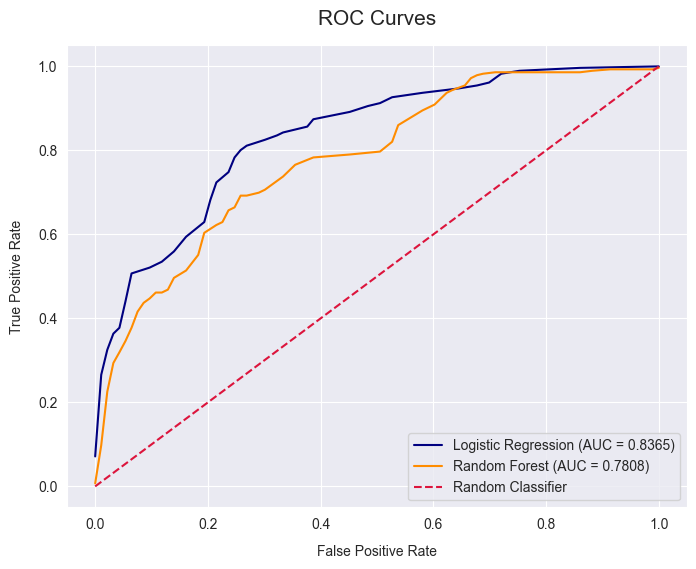

In [143]:
plt.figure(figsize=(8, 6))

# Logistic Regression ROC Curve
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, pred_proba_logreg[:, 1])
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

sns.lineplot(x=fpr_logreg, y=tpr_logreg, 
             label=f'Logistic Regression (AUC = {roc_auc_logreg:.4f})', ci=None, color='navy')

# Random Forest ROC Curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, pred_proba_rf[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

sns.lineplot(x=fpr_rf, y=tpr_rf, 
             label=f'Random Forest (AUC = {roc_auc_rf:.4f})', ci=None, color='darkorange')

# Diagonal (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='crimson', label='Random Classifier')

plt.title('ROC Curves', pad=15, fontsize=15)
plt.xlabel('False Positive Rate', labelpad=10)
plt.ylabel('True Positive Rate', labelpad=10)

plt.legend()
plt.show()

ROC AUC of the Logistic Regression model is higher than the one of the Random Forest, therefore, **Logistic Regression tends to perform better on our data.**

## Part IV. Business Demands
The business, however, wants us to use a different measure of a model's quality: its ability to correctly predict high traffic recipes 80% of the time. This is basically a real ML metric, called **'precision'** _(accuracy of positive predictions made by a classification model, representing the proportion of correctly identified positive instances among all instances predicted as positive)_. 

### KPI Metric: Precision
**Logistic Regression successfully achieves the goal of precision >= 80%, while Random Forest fails to do so:**

In [144]:
prec_logreg = precision_score(y_test, y_pred_logreg)
prec_rf = precision_score(y_test, y_pred_rf)
print(f'Correctly predicted high traffic recipes by Logistic Regression: {round(prec_logreg * 100, 2)}%')
print(f'Correctly predicted high traffic recipes by Random Forest: {round(prec_rf * 100, 2)}%')

Correctly predicted high traffic recipes by Logistic Regression: 82.73%
Correctly predicted high traffic recipes by Random Forest: 77.04%


**Therefore, Logistic Regression model outperforms Random Forest by both metrics (ROC AUC and precision)**, so I've decided to stick with the former and even tune it a little bit _(the code for the Grid Search is commented for the sake of saving time; it's output is presented below):_

In [145]:
print('Optimal parameters:', {'C': 0.1, 'class_weight': 'balanced', \
                              'l1_ratio': 0.0, 'max_iter': 25, \
                              'penalty': 'l2', 'solver': 'liblinear'}, '\n')
print(f'Correctly predicted high traffic recipes by tuned Logistic Regression: 83.2%')

prec_grid = 0.832
best_logreg = LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.0, 
                                 max_iter=25, random_state=42, \
                                 solver='liblinear').fit(X_train, y_train)

Optimal parameters: {'C': 0.1, 'class_weight': 'balanced', 'l1_ratio': 0.0, 'max_iter': 25, 'penalty': 'l2', 'solver': 'liblinear'} 

Correctly predicted high traffic recipes by tuned Logistic Regression: 83.2%


In [146]:
# logreg = LogisticRegression(random_state=42)

# parameters = {'solver': ['newton-cg', 'newton-cholesky', 'sag', 'saga', 'lbfgs', 'liblinear'],
#               'penalty': ['elasticnet', 'l2', 'l1', None], 
#               'class_weight': ['balanced', None],
#               'C': [0.001, 0.01, 0.1, 1, 10, 100], 
#               'l1_ratio': np.linspace(0, 1, 10),
#               'max_iter': [25, 50, 75, 100, 150, 200]}

# grid_logreg = GridSearchCV(estimator=logreg, param_grid=parameters, cv=5, n_jobs=-1, scoring='precision')
# grid_logreg.fit(X_train, y_train)
# best_logreg = grid_logreg.best_estimator_

# print('Optimal parameters:', grid_logreg.best_params_, '\n')

# y_pred_grid = grid_logreg.predict(X_test)
# prec_grid = precision_score(y_test, y_pred_grid)
# print(f'Correctly predicted high traffic recipes by tuned Logistic Regression: {round(prec_grid * 100, 2)}%')

The tuned model is only 0.47% better at correctly predicting high traffic recipes than the baseline Logistic Regression; however, even a small percentage improvement could be valuable for the business. 

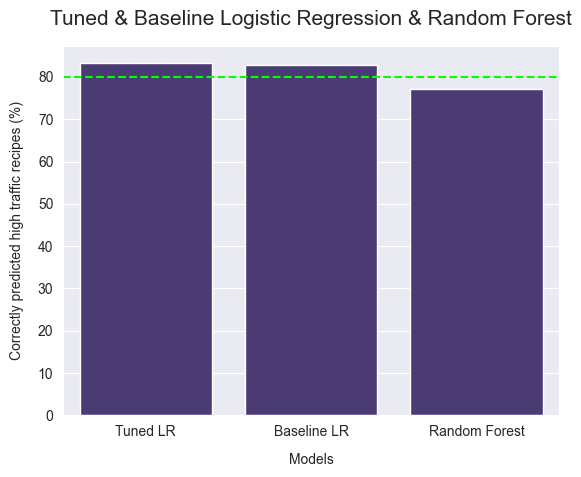

In [147]:
sns.barplot(y=[prec_grid * 100, prec_logreg * 100, prec_rf * 100], 
            x=['Tuned LR', 'Baseline LR', 'Random Forest']) \
            .set_title('Tuned & Baseline Logistic Regression & Random Forest', pad=15, fontsize=15)

plt.axhline(y=80, color='lime', linestyle='--')

plt.xlabel('Models', labelpad=10)
plt.ylabel('Correctly predicted high traffic recipes (%)', labelpad=10)

plt.show()

### Feature Importance
From the graph below you can tell that the **recipes, associated with higher traffic rates, are Vegetable, Potato, and Pork** ones. On the other hand, **Beverage, Breakfast, and Chicken recipes are more likely to lead to lower traffic.** The number of servings and calories in a recipe has almost no effect on the level of traffic it provides:

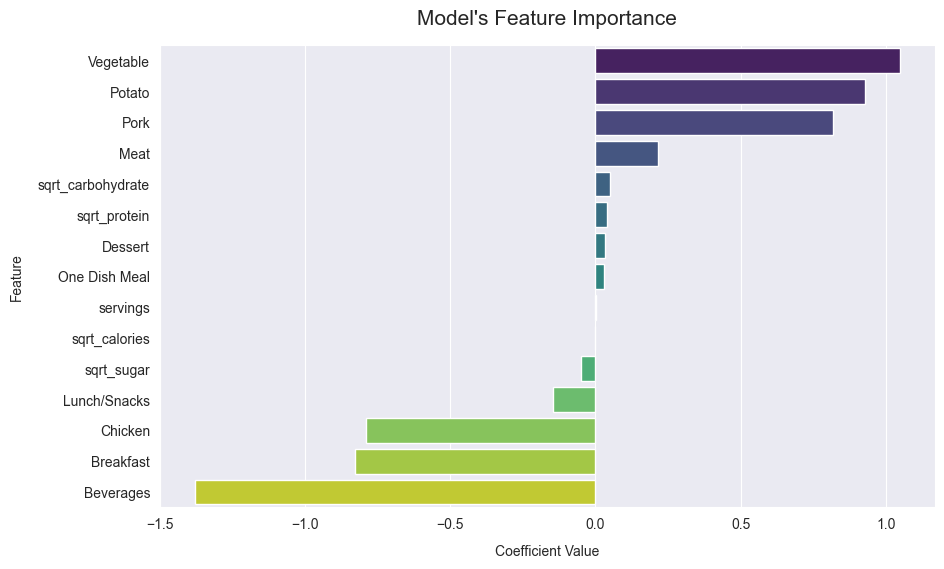

In [148]:
feature_names = ['servings', 'Beverages', 'Breakfast', 'Chicken', 'Dessert',
                 'Lunch/Snacks', 'Meat', 'One Dish Meal', 'Pork', 'Potato',
                 'Vegetable', 'sqrt_calories', 'sqrt_carbohydrate', 'sqrt_sugar', 'sqrt_protein']

coefficients = best_logreg.coef_[0]

df_feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
df_feature_importance = df_feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=df_feature_importance, palette='viridis')

plt.xlabel('Coefficient Value', labelpad=10)
plt.ylabel('Feature', labelpad=10)
plt.title("Model's Feature Importance", pad=15, fontsize=15)
plt.show()

## Part V. Recommendations for the Business
The proposed **model performs well on the test data**: it correctly predicts high traffic recipes 83.2% of the time, so **it should be deployed in production in order to increase the traffic rates on your website**. 

However, it should be validated on the new data you will collect this month, so that we can improve the model (in case its performance drops). Also, you may want to consider displaying new recipes on your homepage, so that new features will be created, which may result in the need to retune the hyperparameters of the model.